### 0.パッケージのインストール

In [1]:
import sys
import os
sys.path.append("../src")

import torch
import matplotlib.pyplot as plt
import numpy as np

from dataset import CustomSegmentationDataset, TestDataset
from utils import DatasetSplitter, JsonUtils
from model import get_deeplabv3plus
from train import train_model
from infer import inference, InferenceVisualizer
import rasterio
import pickle

d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 2. データセットの準備・可視化

In [8]:
# image_dir="../data/raw_train/images"
# annotation_file="../data/raw_train/annotations/train_segmentation_annotations.json"

image_dir = "../data/selected_train/images"
annotation_file = "../data/selected_train/annotations/annotations.json"
output_dir = "../data/v2_dataset"

## 学習用データを分割して学習用(train)と評価用(val)に分ける
splitter = DatasetSplitter(image_dir, annotation_file, output_dir)

splitter.split(test_size=0.2)

✅ Split completed. Train: 1447, Val: 362


In [2]:
# ファイル読み込み先の指定
# train_img_dir = "../data/train/images"
# train_ann_file = "../data/train/annotations/annotations.json"

ver_id = "v2_dataset"
train_img_dir = f"../data/{ver_id}/train/images"
train_ann_file = f"../data/{ver_id}/train/annotations/annotations.json"
val_img_dir = f"../data/{ver_id}/val/images"
val_ann_file = f"../data/{ver_id}/val/annotations/annotations.json"

# annotationラベルの指定
label_map = {
    "background": 0,
    "vacant_lot": 1,
}

train_dataset = CustomSegmentationDataset(train_img_dir, train_ann_file, label_map, transform=None, target_size=(256, 256))
val_dataset = CustomSegmentationDataset(val_img_dir, val_ann_file, label_map, transform=None, target_size=(256, 256))

d:\python_workspace\detect-emptylots\notebooks\../src\dataset.py:27: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


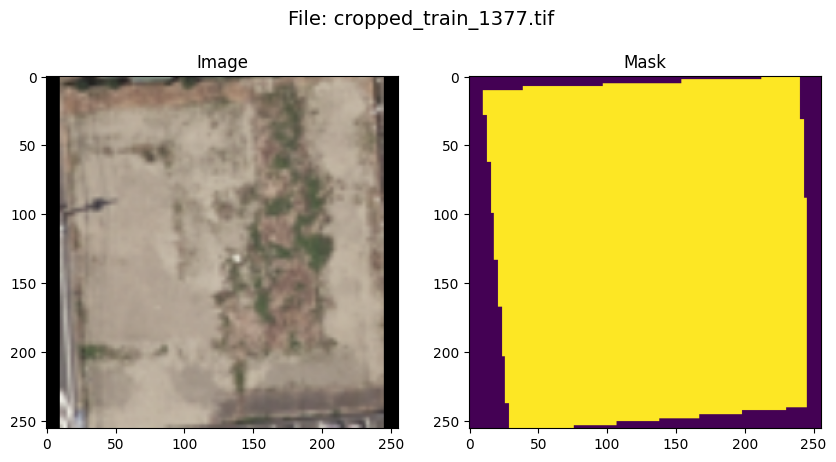

In [7]:
# サンプル画像とマスクの可視化
idx = 200

img, mask = train_dataset[idx]
file_name = train_dataset.annotations_data[idx]['file_name']

plt.figure(figsize=(10,5))
plt.suptitle(f"File: {file_name}", fontsize=14) 
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

### 3. モデルの構築

In [8]:
num_classes = 2  # クラス数に応じて変更
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3plus(num_classes).to(device)

d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 4.学習

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

num_epochs = 10
model, history = train_model(model, train_loader, val_loader, num_epochs=num_epochs, device=device)

Epoch 1/10, Train Loss: 0.3112, Val Loss: 0.2523
Epoch 2/10, Train Loss: 0.2471, Val Loss: 0.2225
Epoch 3/10, Train Loss: 0.2192, Val Loss: 0.2401
Epoch 4/10, Train Loss: 0.2142, Val Loss: 0.1986
Epoch 5/10, Train Loss: 0.1927, Val Loss: 0.2114
Epoch 6/10, Train Loss: 0.1880, Val Loss: 0.1895
Epoch 7/10, Train Loss: 0.1745, Val Loss: 0.1924
Epoch 8/10, Train Loss: 0.1662, Val Loss: 0.1771
Epoch 9/10, Train Loss: 0.1578, Val Loss: 0.1775
Epoch 10/10, Train Loss: 0.1532, Val Loss: 0.1749


In [10]:
# モデルの保存
model_path = "../models/model_v2.pth"
torch.save(model.state_dict(), model_path) # モデルの state_dict（重み）を保存

# 学習履歴の保存
history_path = "../models/history_v2.pth"
torch.save(history, 'history_v2.pth')

In [19]:
# モデルの読み込み
model_path = "../models/model_v2.pth"
model.load_state_dict(torch.load(model_path))

# 学習履歴の読み込み
history_path = "../models/history_v2.pth"
history = torch.load(history_path)

### 5. 検証データで推論

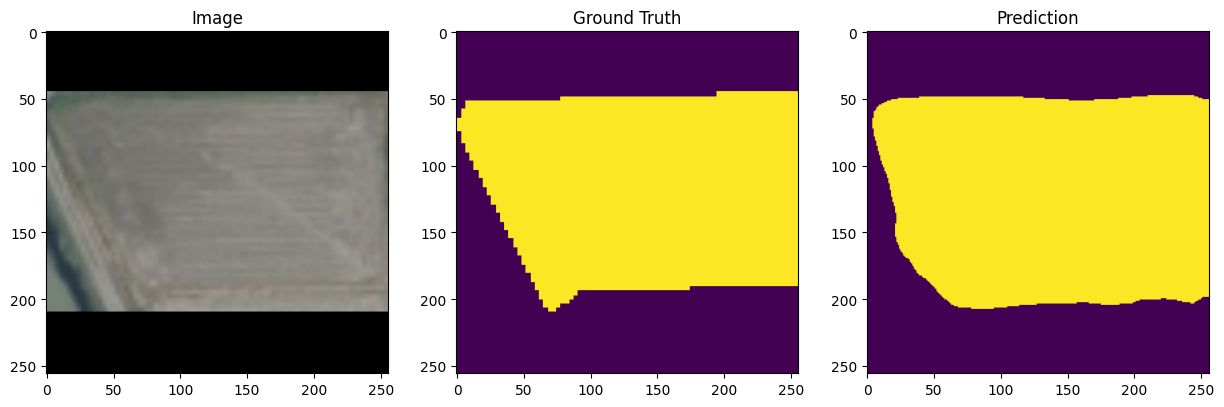

In [13]:
val_img, val_mask = val_dataset[5]
pred_mask = inference(model, val_img, device=device)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(val_img.permute(1, 2, 0).cpu().numpy()) # 画像を(H, W, C)に戻す
plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(val_mask)
plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred_mask)
plt.show()

In [14]:
# 推論を実行して結果を保存
pred_masks = []
for idx in range(len(val_dataset)):
    val_img, _ = val_dataset[idx]
    pred_mask = inference(model, val_img, device=device)
    pred_masks.append(pred_mask)

In [15]:
# 推論結果の可視化と保存
visualizer = InferenceVisualizer(val_dataset)

# 画像、正解マスク、予測マスクを並べて保存
visualizer.visualize_and_save(pred_masks, "../data/val/predictions")

推論結果を ../data/val/predictions に保存しました。


### 7. 追加：学習曲線の可視化（任意）

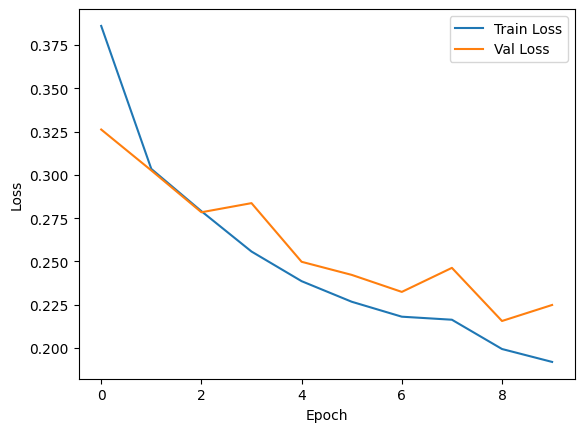

In [21]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 8.テストデータを推論

In [15]:


# テストデータセットの作成
test_dataset = TestDataset(test_img_file, transform=None, target_size=(256, 256))

d:\python_workspace\detect-emptylots\notebooks\../src\dataset.py:90: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


In [7]:
# # 推論を実行して結果をjson保存
# # test_masks = []

# # for idx in range(len(test_dataset)):
# #     test_img, _ = test_dataset[idx]
# #     test_mask = inference(model, test_img, device=device)
# #     test_masks.append(test_mask)

# # 推論結果を保存するためのリスト
# pred_masks = []
# file_names = []
# widths = []
# heights = []

# # 推論を実行
# for idx in range(len(test_dataset)):
#     test_img, file_name = test_dataset[idx]
#     pred_mask = inference(model, test_img, device=device)

#     # 画像サイズを取得
#     image_path = os.path.join(test_dataset.image_dir, file_name)
#     with rasterio.open(image_path) as src:
#         width = src.width
#         height = src.height

#     # 結果を追加
#     pred_masks.append(pred_mask)
#     file_names.append(file_name)
#     widths.append(width)
#     heights.append(height)
    
# # すべての推論結果を1つのJSONファイルに保存
# output_json_path = "../data/test/annotations/predictions_v2.json"
# JsonUtils.mask_to_json(
#     masks=pred_masks,
#     file_names=file_names,
#     output_path=output_json_path,
#     widths=widths,
#     heights=heights
# )

In [8]:
# 推論結果を用いたテストデータセットを作成
test_result = CustomSegmentationDataset(test_img_file, test_ann_file, label_map, transform=None, target_size=(256, 256))

# 推論を実行して結果を保存
pred_masks = []
for idx in range(len(test_result)):
    val_img, _ = test_result[idx]
    # 元の画像サイズを取得
    original_size = (test_result.annotations_data[idx]['height'], test_result.annotations_data[idx]['width'])
    pred_mask = inference(model, val_img, original_size=original_size, device=device)
    pred_masks.append(pred_mask)

# 推論結果の可視化と保存
visualizer = InferenceVisualizer(test_result)

# 画像、正解マスク、予測マスクを並べて保存
visualizer.visualize_and_save(pred_masks, "../data/test/predictions_v2_resize")

推論結果を ../data/test/predictions_v2_resize に保存しました。


In [6]:
# 推論結果を用いたテストデータセットを作成
# test_result = CustomSegmentationDataset(test_img_file, test_ann_file, label_map, transform=None)

test_dataset = TestDataset(test_img_file, transform=None, target_size=(256, 256))
# 推論を実行して結果を保存
pred_masks = []
file_names = []
widths = []
heights = []

for idx in range(len(test_result)):
    val_img, _ = test_result[idx]
    file_name = test_result.annotations_data[idx]['file_name']
    width = test_result.annotations_data[idx]['width']
    height = test_result.annotations_data[idx]['height']
    
    # 元の画像サイズを取得
    original_size = (height, width)
    pred_mask = inference(model, val_img, original_size=original_size, device=device)
    
    # 結果を追加
    pred_masks.append(pred_mask)
    file_names.append(file_name)
    widths.append(width)
    heights.append(height)

# 推論結果をJSONファイルに保存
output_json_path = "../data/test/annotations/predictions_v2_resize.json"
JsonUtils.mask_to_json(
    masks=pred_masks,
    file_names=file_names,
    output_path=output_json_path,
    widths=widths,
    heights=heights
)

KeyboardInterrupt: 

In [17]:
from PIL import Image

# テストデータセットの作成
test_dataset = TestDataset(test_img_file, transform=None, target_size=(256, 256))

# 推論結果を保存するリスト
pred_masks = []
file_names = []
widths = []
heights = []

# 各画像に対して推論を実行
for idx in range(len(test_dataset)):
    # 画像とファイル名を取得
    image, file_name = test_dataset[idx]
    
    # 元の画像サイズを取得
    with Image.open(os.path.join(test_img_file, file_name)) as img:
        width, height = img.size
    
    # 推論を実行
    pred_mask = inference(model, image, original_size=(height, width), device=device)
    
    # 結果を保存
    pred_masks.append(pred_mask)
    file_names.append(file_name)
    widths.append(width)
    heights.append(height)
    
    # 進捗表示
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(test_dataset)} images")

# 推論結果をJSONファイルに保存
JsonUtils.mask_to_json(
    masks=pred_masks,
    file_names=file_names,
    output_path=test_ann_file,
    widths=widths,
    heights=heights
)

d:\python_workspace\detect-emptylots\notebooks\../src\infer.py:30: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4086: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'
